# SQL ALCHEMY

##### Import des librairies nécessaires pour la connexion SQL et la manipulation des données

In [211]:
from sqlalchemy import create_engine, text
import pandas as pd
import seaborn as sns
from datetime import datetime

##### Chemin vers le fichier de base de données SQLite

In [212]:
db_file = "sakila.db"
engine = create_engine(f"sqlite:///{db_file}")

##### Exécute une requête SQL sur une base SQLite

In [213]:
def executer_query(sql_query, params=None):
    try:
        with engine.begin() as connection:
            result = connection.execute(text(sql_query), params or {})
            if result.returns_rows:
                df = pd.DataFrame(result.fetchall(), columns=result.keys())
                return df
            return None
    except Exception as e:
        print(f"Une erreur s'est produite : {e}")
        return None

##### Affichez les **5 titres de films** (`title` de la table `film`) classés par **ordre alphabétique croissant**, en utilisant un **alias** pour la colonne.

In [214]:
sql_titles = """
SELECT title AS "Titre du film"
FROM film
ORDER BY title ASC
LIMIT 5;
"""
df_titles = executer_query(sql_titles)
print(df_titles.to_markdown(index=False))

| Titre du film    |
|:-----------------|
| ACADEMY DINOSAUR |
| ACE GOLDFINGER   |
| ADAPTATION HOLES |
| AFFAIR PREJUDICE |
| AFRICAN EGG      |


##### Calculez la **moyenne**, le **minimum**, le **maximum**, le **nombre total** et la **somme** du champ `length` (durée en minutes) de tous les films dans la table `film`.

In [215]:
sql_stats = """
SELECT 
    AVG(length) AS "Durée Moyenne",
    MIN(length) AS "Durée Min",
    MAX(length) AS "Durée Max",
    COUNT(length) AS "Nombre de Films",
    SUM(length) AS "Somme des Durées"
FROM film;
"""
df_stats = executer_query(sql_stats)
print(df_stats.to_markdown(index=False))

|   Durée Moyenne |   Durée Min |   Durée Max |   Nombre de Films |   Somme des Durées |
|----------------:|------------:|------------:|------------------:|-------------------:|
|         115.272 |          46 |         185 |              1000 |             115272 |


##### Insérez un nouvel acteur avec le prénom "JEAN-CLAUDE", le nom "VANDAMME", le nouvel ID calculé, et la date/heure actuelle pour le champ **`last_update`**

In [216]:
first_name = "JEAN-CLAUDE"
last_name = "VANDAMME"

# Vérifier si l'acteur existe déjà
sql_check = """
SELECT COUNT(*) AS count
FROM actor
WHERE first_name = :first_name AND last_name = :last_name;
"""
df_check = executer_query(sql_check, {"first_name": first_name, "last_name": last_name})

if df_check.iat[0, 0] > 0:
    print(f"L'acteur '{first_name} {last_name}' existe déjà. Aucune insertion effectuée.")
else:
    # Trouver l'actor_id maximum existant et calculer le nouvel ID
    df_max_id = executer_query("SELECT MAX(actor_id) AS max_id FROM actor;")
    raw_id = df_max_id.iat[0, 0] or 0
    nouvel_id = int(raw_id) + 1

    # Préparer les données à insérer
    nouvel_acteur = {
        "actor_id": nouvel_id,
        "first_name": first_name,
        "last_name": last_name,
        "last_update": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }

    # Insérer le nouvel acteur
    sql_insert = """
    INSERT INTO actor (actor_id, first_name, last_name, last_update)
    VALUES (:actor_id, :first_name, :last_name, :last_update);
    """
    executer_query(sql_insert, nouvel_acteur)
    print(f"L'acteur '{first_name} {last_name}' a été inséré avec l'ID {nouvel_id}.")

L'acteur 'JEAN-CLAUDE VANDAMME' a été inséré avec l'ID 216.


##### **Modification (`UPDATE`) par ID :** **Modifiez** l'acteur que vous venez d'insérer (en le ciblant par son **ID unique**) pour changer son prénom de `"JEAN-CLAUDE"` à `"JC"`.

In [217]:
sql_update = """
UPDATE actor
SET first_name = :new_first_name, last_update = :last_update
WHERE actor_id = :actor_id;
"""
executer_query(sql_update, {
    "new_first_name": "JC",
    "last_update": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "actor_id": nouvel_id
})

# Vérifier la modification
sql_verif = "SELECT actor_id, first_name, last_name FROM actor WHERE actor_id = :actor_id;"
df_verif = executer_query(sql_verif, {"actor_id": nouvel_id})
print(df_verif.to_markdown(index=False))

|   actor_id | first_name   | last_name   |
|-----------:|:-------------|:------------|
|        216 | JC           | VANDAMME    |


##### Créez un **histogramme** (*histplot*) avec Seaborn pour visualiser la **distribution** de la colonne `rental_rate`.

<Axes: xlabel='rental_rate', ylabel='Count'>

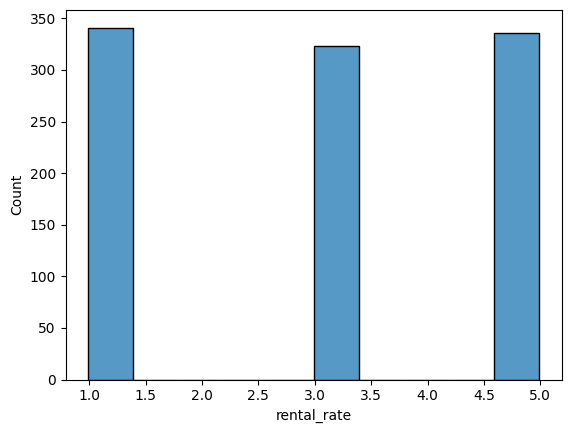

In [218]:
# Récupération des valeurs rental_rate
sql_rental_rate = """
SELECT rental_rate
FROM film;
"""

df_rental_rate = executer_query(sql_rental_rate)

# Création de l'histogramme avec Seaborn
sns.histplot(df_rental_rate["rental_rate"], bins=10, kde=False)

##### ** Créez un **diagramme à barres** (*barplot*) avec Seaborn pour comparer visuellement la durée moyenne (`avg_length`) pour chaque catégorie de classification (`rating`).

<Axes: xlabel='Classification', ylabel='Durée Moyenne'>

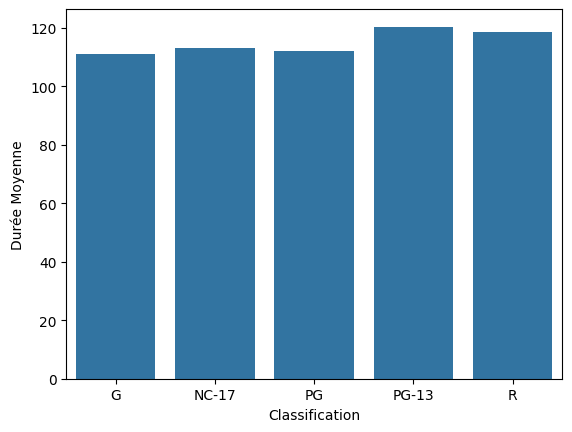

In [219]:
# Requête SQL pour calculer la durée moyenne par classification
sql_avg_length_by_rating = """
SELECT 
    rating AS "Classification",
    AVG(length) AS "Durée Moyenne"
FROM film
GROUP BY rating
ORDER BY rating;
"""

# Exécution de la requête
df_avg_length = executer_query(sql_avg_length_by_rating)

sns.barplot(
    data=df_avg_length,
    x="Classification",
    y="Durée Moyenne"
)

##### **Jointure Simple à 2 Tables**
**Objectif :** Relier la table `customer` à la table `rental` pour identifier les clients les plus récents et actifs.  
**Description :** On récupère les 10 clients (`first_name`, `last_name`) ayant effectué leur location la plus récente, avec la date de location (`rental_date`).  


In [220]:
# Requête SQL : Jointure simple pour trouver les 10 clients ayant loué le plus récemment
sql_clients_recents = """
SELECT 
    c.first_name AS Prenom,
    c.last_name AS Nom,
    r.rental_date AS Date_Location
FROM customer AS c
INNER JOIN rental AS r
    ON c.customer_id = r.customer_id
ORDER BY r.rental_date DESC
LIMIT 10;
"""

# Exécution de la requête
df_clients_recents = executer_query(sql_clients_recents)

# Affichage des résultats
print(df_clients_recents.to_markdown(index=False))

| Prenom   | Nom      | Date_Location           |
|:---------|:---------|:------------------------|
| LOUIS    | LEONE    | 2006-02-14 15:16:03.000 |
| NEIL     | RENNER   | 2006-02-14 15:16:03.000 |
| NATALIE  | MEYER    | 2006-02-14 15:16:03.000 |
| JEREMY   | HURTADO  | 2006-02-14 15:16:03.000 |
| NAOMI    | JENNINGS | 2006-02-14 15:16:03.000 |
| REGINA   | BERRY    | 2006-02-14 15:16:03.000 |
| GREG     | ROBINS   | 2006-02-14 15:16:03.000 |
| JENNY    | CASTRO   | 2006-02-14 15:16:03.000 |
| BECKY    | MILES    | 2006-02-14 15:16:03.000 |
| ALBERT   | CROUSE   | 2006-02-14 15:16:03.000 |


##### **Jointure à 3 Tables**
**Objectif :** Relier les locations (`rental`) aux films (`film`) via l’inventaire (`inventory`) pour analyser les transactions récentes.  
**Description :** On récupère le titre des films (`title`) et la date de location (`rental_date`) pour les 5 dernières locations de films classés `'PG-13'`.

In [221]:
# Requête SQL : Jointure à 3 tables pour les 5 dernières locations de films PG-13
sql_derniers_films_pg13 = """
SELECT 
    f.title AS Titre_Film,
    r.rental_date AS Date_Location
FROM rental AS r
INNER JOIN inventory AS i
    ON r.inventory_id = i.inventory_id
INNER JOIN film AS f
    ON i.film_id = f.film_id
WHERE f.rating = 'PG-13'
ORDER BY r.rental_date DESC
LIMIT 5;
"""

# Exécution de la requête
df_derniers_films_pg13 = executer_query(sql_derniers_films_pg13)

# Affichage des résultats
print(df_derniers_films_pg13.to_markdown(index=False))


| Titre_Film         | Date_Location           |
|:-------------------|:------------------------|
| WORLD LEATHERNECKS | 2006-02-14 15:16:03.000 |
| WANDA CHAMBER      | 2006-02-14 15:16:03.000 |
| THEORY MERMAID     | 2006-02-14 15:16:03.000 |
| SWARM GOLD         | 2006-02-14 15:16:03.000 |
| STREAK RIDGEMONT   | 2006-02-14 15:16:03.000 |


##### **Jointure à 4 Tables (Many-to-Many)**
**Objectif :** Traverser la table de liaison `film_actor` pour relier les acteurs aux films et ajouter la dimension langue (`language`).  
**Description :** On liste les 15 premiers acteurs (`first_name`, `last_name`) ayant joué dans des films dont la langue originale est `'English'`.

In [222]:
# Requête SQL : Jointure à 4 tables pour les acteurs de films en anglais
sql_acteurs_anglais = """
SELECT DISTINCT
    a.first_name AS Prenom,
    a.last_name AS Nom
FROM actor AS a
INNER JOIN film_actor AS fa
    ON a.actor_id = fa.actor_id
INNER JOIN film AS f
    ON fa.film_id = f.film_id
INNER JOIN language AS l
    ON f.language_id = l.language_id
WHERE l.name = 'English'
ORDER BY a.last_name ASC
LIMIT 15;
"""

# Exécution de la requête
df_acteurs_anglais = executer_query(sql_acteurs_anglais)

# Affichage des résultats
print(df_acteurs_anglais.to_markdown(index=False))


| Prenom    | Nom       |
|:----------|:----------|
| CHRISTIAN | AKROYD    |
| KIRSTEN   | AKROYD    |
| DEBBIE    | AKROYD    |
| CUBA      | ALLEN     |
| KIM       | ALLEN     |
| MERYL     | ALLEN     |
| ANGELINA  | ASTAIRE   |
| RUSSELL   | BACALL    |
| JESSICA   | BAILEY    |
| AUDREY    | BAILEY    |
| HARRISON  | BALE      |
| RENEE     | BALL      |
| JULIA     | BARRYMORE |
| VIVIEN    | BASINGER  |
| SCARLETT  | BENING    |


##### **Jointure à 5 Tables (Transaction et Structure)**
**Objectif :** Relier les locations (`rental`) aux films (`film`), en ajoutant la dimension humaine (`staff`) et structurelle (`store`).  
**Description :** Pour le magasin n°2, on récupère les 5 derniers films loués avec la date de location et le prénom/nom de l’employé qui a géré la transaction.

In [223]:
# Requête SQL : Jointure à 5 tables pour les 5 derniers films loués au magasin n°2
sql_derniers_films_store2 = """
SELECT 
    f.title AS Titre_Film,
    r.rental_date AS Date_Location,
    st.first_name AS Prenom_Employe,
    st.last_name AS Nom_Employe
FROM rental AS r
INNER JOIN inventory AS i
    ON r.inventory_id = i.inventory_id
INNER JOIN film AS f
    ON i.film_id = f.film_id
INNER JOIN store AS s
    ON i.store_id = s.store_id
INNER JOIN staff AS st
    ON r.staff_id = st.staff_id
WHERE s.store_id = 2
ORDER BY r.rental_date DESC
LIMIT 5;
"""

# Exécution de la requête
df_derniers_films_store2 = executer_query(sql_derniers_films_store2)

# Affichage des résultats
print(df_derniers_films_store2.to_markdown(index=False))


| Titre_Film       | Date_Location           | Prenom_Employe   | Nom_Employe   |
|:-----------------|:------------------------|:-----------------|:--------------|
| ACE GOLDFINGER   | 2006-02-14 15:16:03.000 | Mike             | Hillyer       |
| AFFAIR PREJUDICE | 2006-02-14 15:16:03.000 | Mike             | Hillyer       |
| AFRICAN EGG      | 2006-02-14 15:16:03.000 | Jon              | Stephens      |
| ALI FOREVER      | 2006-02-14 15:16:03.000 | Mike             | Hillyer       |
| AMADEUS HOLY     | 2006-02-14 15:16:03.000 | Mike             | Hillyer       |


##### **Jointure de Navigation et Agrégation (6 Tables)**
**Objectif :** Naviguer à travers plusieurs tables (`customer`, `address`, `city`, `country`, `payment`) pour filtrer les clients par ville et calculer le montant total de leurs paiements.  
**Description :** On récupère le prénom et le nom des clients vivant à "London" et dont le montant total des paiements dépasse 100.


In [227]:
# Requête SQL : Montant total des paiements par clients à London > 100
sql_clients_london = """
SELECT 
    c.first_name AS Prenom,
    c.last_name AS Nom,
    SUM(p.amount) AS Total_Paiements
FROM customer AS c
INNER JOIN address AS a
    ON c.address_id = a.address_id
INNER JOIN city AS ci
    ON a.city_id = ci.city_id
INNER JOIN country AS co
    ON ci.country_id = co.country_id
INNER JOIN payment AS p
    ON c.customer_id = p.customer_id
WHERE ci.city = 'London'
GROUP BY c.customer_id, c.first_name, c.last_name
HAVING SUM(p.amount) > 100
ORDER BY Total_Paiements DESC;
"""

# Exécution de la requête
df_clients_london = executer_query(sql_clients_london)

# Affichage des résultats
print(df_clients_london.to_markdown(index=False))


| Prenom   | Nom   |   Total_Paiements |
|:---------|:------|------------------:|
| CECIL    | VINES |            115.74 |
